<a href="https://colab.research.google.com/github/pachterlab/BP_2020_2/blob/master/notebooks/log1p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!date

Sat May 16 19:17:26 UTC 2020


# Install software

In [3]:
!pip install anndata

     |████████████████████████████████| 102kB 2.7MB/s 


# Download data

In [4]:
!git clone https://github.com/pachterlab/BP_2020_2.git

Cloning into 'BP_2020_2'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 9), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (36/36), done.
Checking out files: 100% (17/17), done.


In [0]:
!cat BP_2020_2/data/raw/top BP_2020_2/data/raw/bot > BP_2020_2/data/raw/mtx
!cat BP_2020_2/data/norm/top BP_2020_2/data/norm/bot > BP_2020_2/data/norm/mtx

# Log1p

In [0]:
import pandas as pd
import numpy as np
import anndata

from sklearn.preprocessing import normalize, scale
from collections import OrderedDict

from scipy.io import mmread
from scipy.sparse import csr_matrix
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


age_map = {
    "SRR8426358": 24,
    "SRR8426359": 24,
    "SRR8426362": 24,
    "SRR8426363": 24,
    "SRR8426364": 24,
    "SRR8426369": 24,
    "SRR8426370": 24,
    "SRR8426360": 3,
    "SRR8426361": 3,
    "SRR8426365": 3,
    "SRR8426366": 3,
    "SRR8426367": 3,
    "SRR8426368": 3,
    "SRR8426371": 3,
    "SRR8426372": 3
}

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Load matrix

In [0]:
ace2_gene = "ENSMUSG00000015405"

In [0]:
bp = "BP_2020_2/data/"
obs = pd.read_csv(bp + "raw/E-CURD-9.aggregated_filtered_counts.mtx_cols", sep="\t", header=None, names=["SRR_bcs"])
var = pd.read_csv(bp + "raw/E-CURD-9.aggregated_filtered_counts.mtx_rows", sep="\t", header=None, names=["gene", "gene2"])
md  = pd.read_csv(bp + "metadata.txt", sep="\t")
del var["gene2"]
mtx = csr_matrix(mmread(bp+"raw/mtx").T)

md["age"] = md["Factor Value[age]"].str.split(" ").apply(lambda x: x[0])
md.index = md["Assay"].values

obs["SRR"] = obs.SRR_bcs.str.split("-").apply(lambda x: x[0])
obs["bcs"] = obs.SRR_bcs.str.split("-").apply(lambda x: x[1])
obs["age"] = obs.SRR.map(age_map)
obs["age"] = obs.SRR_bcs.map(md["age"])

In [9]:
adata = anndata.AnnData(X=mtx, obs=obs, var=var)
adata = adata[adata.obs.dropna(subset=["age"]).index] # There are 298 cells that are not in the "age_map", with only 1 cell expressing Ace2. We drop it.
adata.obs["age"] = adata.obs.age.astype(int)

Transforming to str index.
Transforming to str index.
Trying to set attribute `.obs` of view, copying.


In [10]:
adata

AnnData object with n_obs × n_vars = 11887 × 19632 
    obs: 'SRR_bcs', 'SRR', 'bcs', 'age'
    var: 'gene'

In [0]:
ace2 = adata[:, np.where(adata.var["gene"]==ace2_gene)[0][0]]

In [0]:
df = ace2.obs.copy()
df["cnt"] = nd(ace2.X.todense())
df["age"] = df.age.values.astype(int)

In [13]:
df.head()

,SRR_bcs,SRR,bcs,age,cnt
0,SRR8426368-TAGCTGAATGAG,SRR8426368,TAGCTGAATGAG,3,0.0
1,SRR8426368-CATGGCAAGGTT,SRR8426368,CATGGCAAGGTT,3,0.0
2,SRR8426368-TGTCGCCGCAAA,SRR8426368,TGTCGCCGCAAA,3,0.0
3,SRR8426368-GCTACTATGGAT,SRR8426368,GCTACTATGGAT,3,0.0
4,SRR8426368-ATTAAAGCCATC,SRR8426368,ATTAAAGCCATC,3,0.0


In [14]:
print("There are a total of {:,.0f} counts of ACE2 among {:,.0f} cells".format(nd(df.cnt).sum(), df.shape[0]))

There are a total of 148 counts of ACE2 among 11,887 cells


In [15]:
print("Total number of age 3  cells: {:,.0f}\t({:,.2f}%)".format(df.eval("age==3").sum(), df.eval("age==3").sum()/df.shape[0]*100))
print("Total number of age 24 cells: {:,.0f}\t({:,.2f}%)".format(df.eval("age==24").sum(), df.eval("age==24").sum()/df.shape[0]*100))

Total number of age 3  cells: 6,581	(55.36%)
Total number of age 24 cells: 5,306	(44.64%)


In [16]:
total_cnt = df.cnt.sum()
print("Total ACE2 counts (percentage of total) in age 3  cells: {:,.0f}\t({:,.2f}%)".format(df.query("age == 3 ").cnt.sum(), df.query("age==3").cnt.sum()/total_cnt*100))
print("Total ACE2 counts (percentage of total) in age 24 cells: {:,.0f}\t({:,.2f}%)".format(df.query("age == 24 ").cnt.sum(), df.query("age==24").cnt.sum()/total_cnt*100))

Total ACE2 counts (percentage of total) in age 3  cells: 102	(68.92%)
Total ACE2 counts (percentage of total) in age 24 cells: 46	(31.08%)


In [17]:
print("Number of ACE2+ age 3  cells (% of age 3  cells): {:,.0f}\t({:,.4f}%)".format(df.query("age==3").eval("cnt>0").sum(), df.query("age==3").eval("cnt>0").sum()/df.query("age==3").shape[0]*100))
print("Number of ACE2+ age 24 cells (% of age 24 cells): {:,.0f}\t({:,.4f}%)".format(df.query("age==24").eval("cnt>0").sum(), df.query("age==24").eval("cnt>0").sum()/df.query("age==24").shape[0]*100))

Number of ACE2+ age 3  cells (% of age 3  cells): 89	(1.3524%)
Number of ACE2+ age 24 cells (% of age 24 cells): 39	(0.7350%)


In [0]:
def vars(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

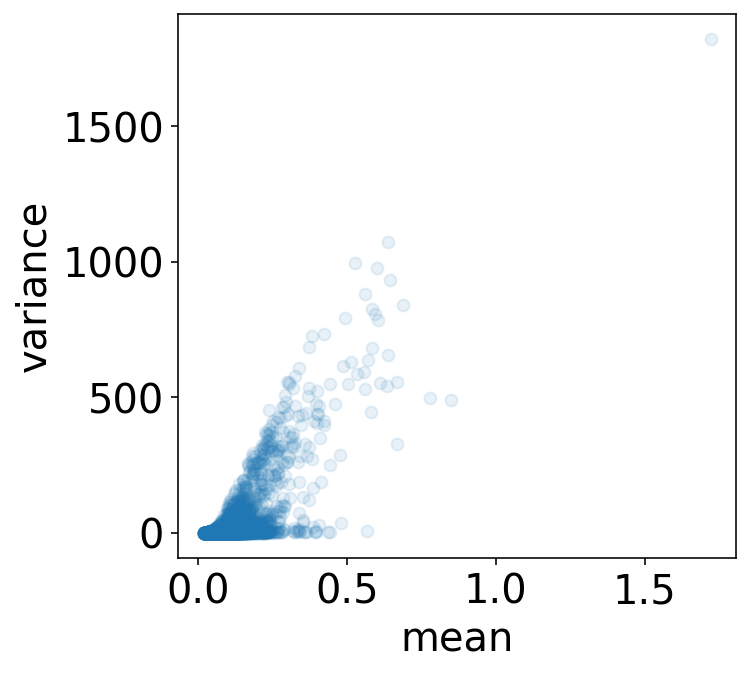

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.X.mean(axis=1))
y = nd(vars(adata.X, axis=1))

ax.scatter(x, y, alpha=0.1)
ax.set(xlabel="mean", ylabel='variance')


plt.show()

In [0]:
#adata = adata[nd((adata.X>0).sum(axis=1)>=500)]

In [27]:
adata

AnnData object with n_obs × n_vars = 11887 × 19632 
    obs: 'SRR_bcs', 'SRR', 'bcs', 'age'
    var: 'gene'
    uns: 'log1p'
    layers: 'raw', 'norm', 'log1p', 'scale'

# Process matrix

In [0]:
adata.layers["raw"] = adata.X
scale_num = 1000000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.layers["scale"] = scale(adata.layers["log1p"].todense(), axis=0, with_mean=True, with_std=True, copy=True)
# adata.X = adata.layers["scale"]

In [0]:
def bplot(x, y, ax):
    #parts = ax.boxplot(
    #    y, widths=0.5, showfliers=False)
    
    for i, j in zip(x,y):
        xx = np.random.normal(i, 0.1, size=len(j))
        ax.scatter(xx, j, color="k", s=10)

        ax.scatter(i, j.mean(), color="#D43F3A")
      

    return ax

In [28]:
nd((adata.layers["raw"]>0).sum(axis=1)>=500).sum()

8320

In [0]:
# Need to do this per replicate

In [0]:
ace_idx = np.where(adata.var.gene.values==ace2_gene)[0][0] # ACE2 index
young_mask = adata.obs.eval("age==3").values # mask for young cells
old_mask = adata.obs.eval("age==24").values # mask for old cells

gene_filter = nd((adata.layers["raw"]>0).sum(axis=1)>=500) # filter cells where there are less than 500 genes
m = nd(adata.layers["raw"].todense()[:,ace_idx])>0 # filter cells with zero amount of 

young_mask = np.logical_and.reduce([young_mask, m, gene_filter])
old_mask = np.logical_and.reduce([old_mask, m, gene_filter])


X = adata.layers["raw"][:,ace_idx].todense()
#X = np.log1p(adata.layers["raw"][:,ace_idx].todense())


In [0]:
X_young = nd(X[young_mask])
X_old   = nd(X[old_mask])

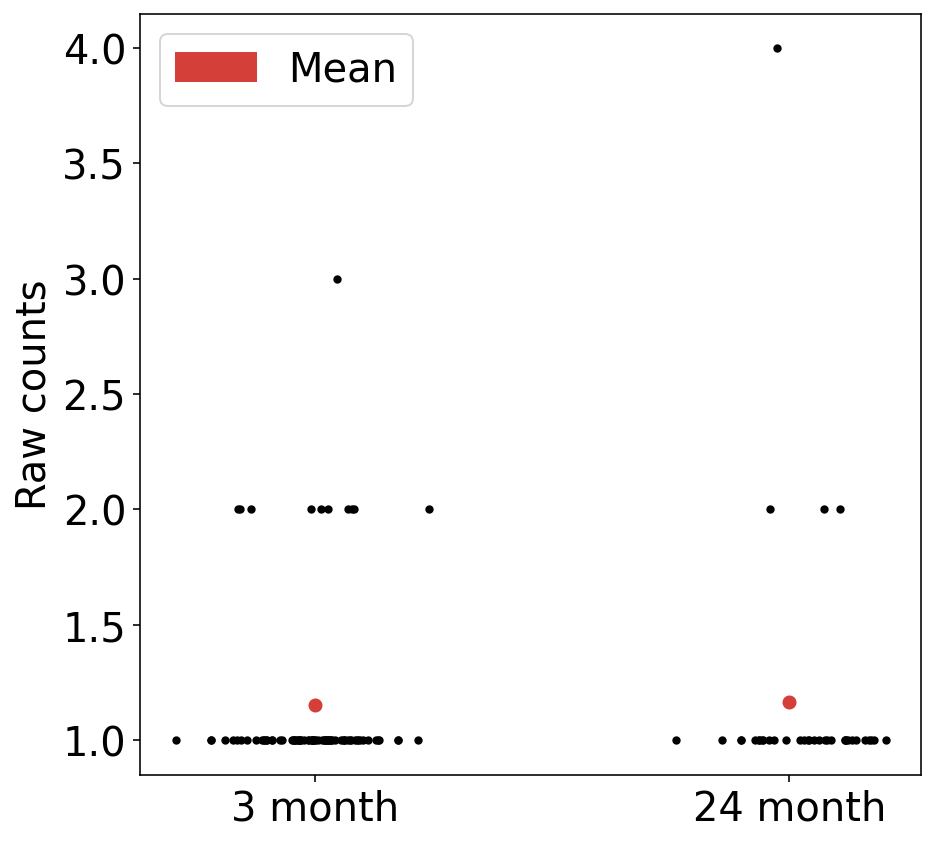

In [122]:
fig, ax = plt.subplots(figsize=(7,7))

xlabels = ["3 month", "24 month"]
xidx = np.arange(len(xlabels))+1
y = [X_young, X_old]

bplot(xidx, y, ax)


ax.set_xticks(xidx)
ax.set_xticklabels(xlabels, ha="center")
ax.set_ylabel("Raw counts")
#ax.set_ylim((-0.1, 5))


mean = mpatches.Patch(color="#D43F3A", label='Mean')
ax.legend(handles=[mean])
#ax.set_title("Limit of detection: {} {} {}".format("Plate2", "S", "Twist"))
#plt.savefig("./figs/recall_{}_{}_{}.png".format("Plate2", "S2", "Twist"),bbox_inches='tight', dpi=300)

plt.show()

# Simulation

In [0]:
n = 2000
m = 100
lam = np.linspace(0.001, 5, n)

In [0]:
fracgz = np.zeros_like(lam)
for lidx, l in enumerate(lam):
    x = np.random.poisson(l,m)
    fracgz[lidx] = (x>0).sum()/x.shape[0]

In [0]:
log1p = np.zeros_like(lam)
for lidx, l in enumerate(lam):
    log1p[lidx] = np.log1p(np.random.poisson(l,m)).mean()

In [0]:
naivelog1p = np.zeros_like(lam)
for lidx, l in enumerate(lam):
    naivelog1p[lidx] = np.log1p(lam[lidx])

In [0]:
funlog1p = np.zeros_like(lam)
for lidx, l in enumerate(lam):
    funlog1p[lidx] = np.log1p(lam[lidx]) - lam[lidx]/(2*(1+lam[lidx])*(1+lam[lidx]))

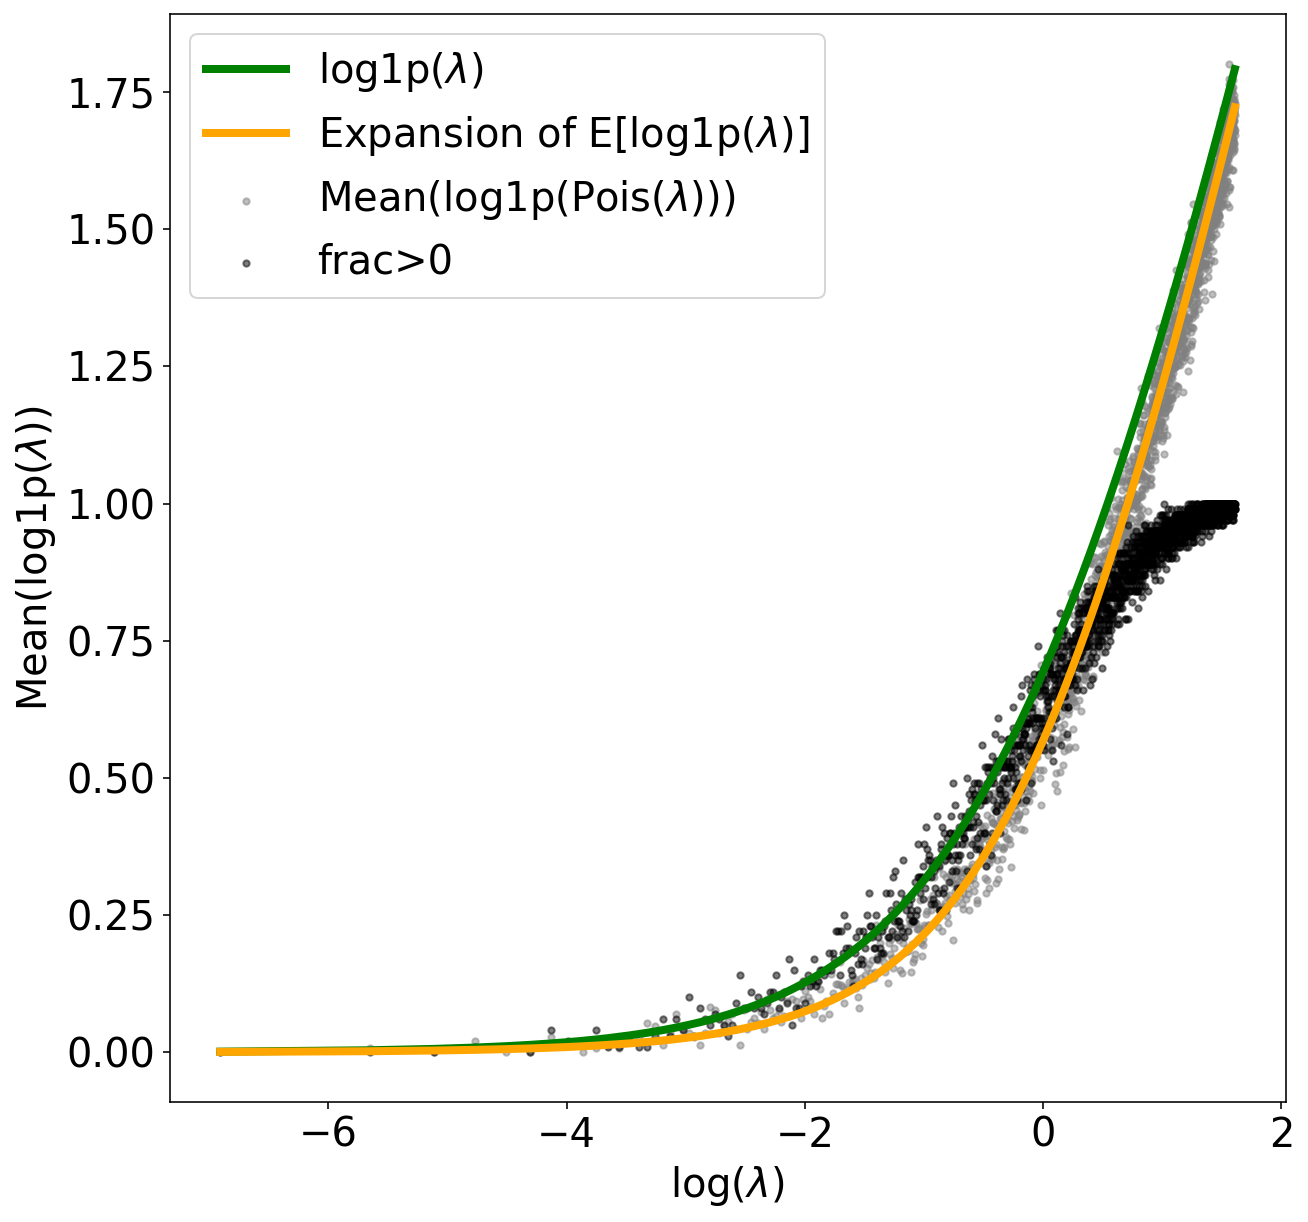

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

red, blue = ("#D43F3A","#3182bd")
lwidth = 4
msize = 10
lam3  = np.log(df.query("age==3").cnt.mean())
lam24 = np.log(df.query("age==24").cnt.mean())

x = np.log(lam)
y = log1p

ax.scatter(x,y, s=msize, label="Mean(log1p(Pois($\lambda$)))", color="grey", alpha=0.5)

x = np.log(lam)
y = naivelog1p

ax.plot(x,y, linewidth = lwidth, label = "log1p($\lambda$)", color="green")

x = np.log(lam)
y = funlog1p

ax.plot(x,y, linewidth=lwidth, label="Expansion of E[log1p($\lambda$)]", color="orange")

x = np.log(lam)
y = fracgz

ax.scatter(x,y, s=msize,alpha=0.5, label="frac>0", color="k")

ax.set_xlabel("log($\lambda$)")
ax.set_ylabel("Mean(log1p($\lambda$))")

ax.legend()

plt.show()